In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Step 1: Load Dataset
# -------------------------------
df = pd.read_csv("/content/data.csv")

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Dataset shape: (5600, 15)
Columns: ['Company_Name', 'Founder_Name', 'Founder_linkedin_id', 'No_of_Employees', 'Funding_Type', 'Year_Founded', 'Software_Type', 'Industry_Type', 'Category', 'Size_of_Company', 'Company_Website', 'Company_Linkedin_id', 'City', 'Address', 'Short_Desription']
     Company_Name         Founder_Name  \
0            3dMD         Kelly Duncan   
1       86Borders    Michael McChesney   
2      Absolute E       Srini Centhala   
3  Absolute Value   Mary Triggs Lanham   
4       accessnow  Francesco Quinterno   

                                 Founder_linkedin_id  No_of_Employees  \
0             https://www.linkedin.com/in/kelduncan/  11-50 employees   
1            https://www.linkedin.com/in/mmcchesney/  11-50 employees   
2  https://www.linkedin.com/in/srini-centhala-590...  11-50 employees   
3  https://www.linkedin.com/in/mary-triggs-lanham...  11-50 employees   
4            https://www.linkedin.com/in/fquinterno/   1-10 employees   

  Funding_Type Year_

In [ ]:
print("Columns:", df.columns)

Columns: Index(['Company_Name', 'Founder_Name', 'Founder_linkedin_id',
       'No_of_Employees', 'Funding_Type', 'Year_Founded', 'Software_Type',
       'Industry_Type', 'Category', 'Size_of_Company', 'Company_Website',
       'Company_Linkedin_id', 'City', 'Address', 'Short_Desription'],
      dtype='object')


In [ ]:
print("\n📊 BASIC INSIGHTS")
print("Total Companies :", df["Company_Name"].nunique())
print("Total Founders  :", df["Founder_Name"].nunique())
print("Top City        :", df["City"].mode()[0])


📊 BASIC INSIGHTS
Total Companies : 5095
Total Founders  : 4737
Top City        : Dallas


In [ ]:
print("\n📈 Companies Founded Per Year")
yearly_counts = df["Year_Founded"].value_counts().sort_index()
print(yearly_counts)



📈 Companies Founded Per Year
Year_Founded
07-11-1905      1
1833            3
1859            1
1867            2
1892            1
             ... 
2019          123
2020          119
2021           43
2022           14
2023            2
Name: count, Length: 80, dtype: int64


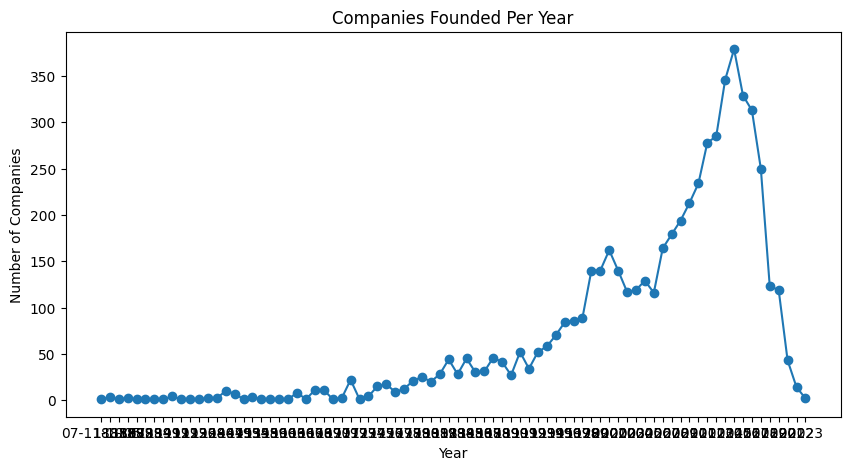

In [ ]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.xlabel("Year")
plt.ylabel("Number of Companies")
plt.title("Companies Founded Per Year")
plt.show()

In [ ]:
print("\n🏭 Top 10 Industries in SaaS Companies")
industry_counts = df["Industry_Type"].value_counts().nlargest(10)
print(industry_counts)



🏭 Top 10 Industries in SaaS Companies
Industry_Type
Horizontal                            3095
Healthcare                             536
Financial Services                     214
Retail                                 171
Education                              159
Real Estate                            155
Energy, Gas, Oil, Utilities            149
Entertainment, Hospitality, Travel     145
Government                             135
Construction                           111
Name: count, dtype: int64


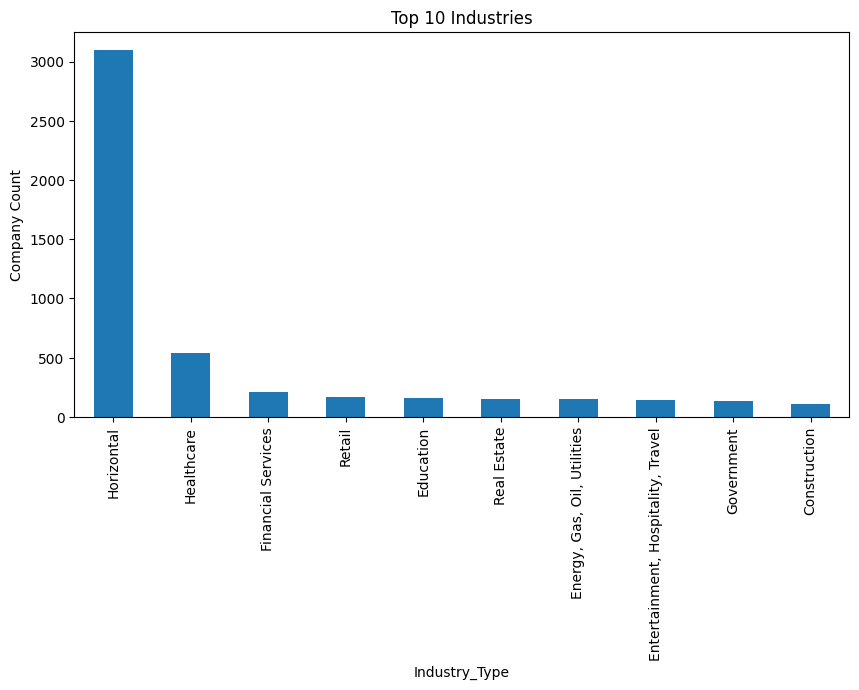

In [ ]:
# Plot
industry_counts.plot(kind="bar", figsize=(10,5), title="Top 10 Industries")
plt.ylabel("Company Count")
plt.show()

In [ ]:
col_map = {}

for col in df.columns:
    c = col.lower()
    if "name" in c:
        col_map["company_name"] = col
    elif "industry" in c:
        col_map["industry"] = col
    elif "city" in c or "location" in c:
        col_map["city"] = col
    elif "founded" in c or "year" in c:
        col_map["Year_Founded"] = col
    elif "funding" in c:
        col_map["Funding_Type"] = col
    elif "size" in c:
        col_map["Size_of_Company"] = col
    elif "desc" in c:
        col_map["description"] = col

print("\nColumn mapping detected:", col_map)

# Rename detected columns
df = df.rename(columns={v: k for k, v in col_map.items()})


Column mapping detected: {'company_name': 'Founder_Name', 'Funding_Type': 'Funding_Type', 'Year_Founded': 'Year_Founded', 'industry': 'Industry_Type', 'Size_of_Company': 'Size_of_Company', 'city': 'City'}


In [ ]:
# -------------------------------
# Step 2: Fill Missing Description
# -------------------------------
if "description" not in df.columns:
    df["description"] = (
        df.get("company_name", "").astype(str) + " is a company in the " +
        df.get("industry", "").astype(str) + " industry, based in " +
        df.get("city", "").astype(str) + ". It was founded in " +
        df.get("Year_Founded", "").astype(str) + " and has funding type " +
        df.get("Funding_Type", "").astype(str) + "."
    )

# -------------------------------
# Step 3: Build Graph
# -------------------------------
G = nx.Graph()

for _, row in df.iterrows():
    G.add_node(
        row.get("company_name", f"Company_{_}"),
        industry=row.get("industry", "Unknown"),
        city=row.get("city", "Unknown"),
        size=row.get("Size_of_Company", "Unknown"),
        funding=row.get("Funding_Type", "Unknown"),
        founded=row.get("Year_Founded", "Unknown")
    )

# Connect companies in same industry
if "industry" in df.columns:
    for industry, group in df.groupby("industry"):
        companies = list(group["company_name"])
        for i in range(len(companies)):
            for j in range(i+1, len(companies)):
                G.add_edge(companies[i], companies[j], relation="same_industry")

print("\nGraph created with", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")



Graph created with 4738 nodes and 3523469 edges


In [ ]:
print("\n⚡ Calculating Centrality Measures (using fast approximation for betweenness)...")

# Degree Centrality (fast)
degree_centrality = nx.degree_centrality(G)
df["Degree_Centrality"] = df["company_name"].map(degree_centrality)

# Show top 10 companies by Degree Centrality
print("\nTop 10 Companies by Degree Centrality:")
print(df.sort_values("Degree_Centrality", ascending=False)
        .head(10)[["company_name", "industry", "Degree_Centrality"]])


⚡ Calculating Centrality Measures (using fast approximation for betweenness)...

Top 10 Companies by Degree Centrality:
     company_name                     industry  Degree_Centrality
4967         Null                   Horizontal           0.982056
4934         Null                   Horizontal           0.982056
1067         Null                   Horizontal           0.982056
1080         Null                   Horizontal           0.982056
5573         Null  Energy, Gas, Oil, Utilities           0.982056
1030         Null                   Automotive           0.982056
5012         Null                   Horizontal           0.982056
3273         Null                   Horizontal           0.982056
3259         Null                         Food           0.982056
127          Null                   Horizontal           0.982056


In [ ]:
print("\n⚡ Calculating Approximate Betweenness Centrality (very fast)...")

# Take top 200 nodes by degree
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:200]
top_nodes = [n for n, _ in top_nodes]


⚡ Calculating Approximate Betweenness Centrality (very fast)...


In [ ]:
betweenness_centrality = nx.betweenness_centrality_subset(
    G, sources=top_nodes, targets=top_nodes, normalized=True
)
df["Betweenness_Centrality"] = df["company_name"].map(betweenness_centrality)

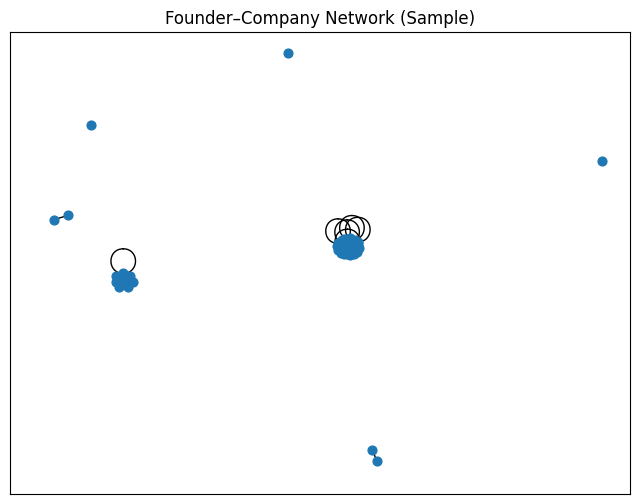

In [ ]:
# Visualize sample graph
plt.figure(figsize=(8,6))
subgraph_nodes = list(G.nodes)[:50]
nx.draw_networkx(G.subgraph(subgraph_nodes), with_labels=False, node_size=40)
plt.title("Founder–Company Network (Sample)")
plt.show()

In [ ]:
# Step 5: Community Detection
# -------------------------------
communities = nx.community.louvain_communities(G, seed=42)
print("\nSample Clusters (first 5):")
for i, comm in enumerate(communities[:5]):
    print(f"Cluster {i+1}: {list(comm)[:10]}...")


Sample Clusters (first 5):
Cluster 1: ['Steve Stinson', 'Steve Roberson', 'Gururaj "Guru" Rao', 'Adam Rotman', 'Eric Gould Bear', 'Dante Cullari', 'Stefan Washietl', 'Dinesh Jain', 'Ryan Wedig', 'Jim Bryant']...
Cluster 2: ['Marisha Mets', 'David Ternan', 'Neil Smiley', 'Christopher Galassi', 'Shayan Zedeh', 'Kevin Henry', 'Ron Remy', 'Steve Mortenson', 'CEO & President', 'Kaleim Manji']...
Cluster 3: ['Sean Maney', 'Connor English', 'Vivek Ghai', 'Rick Sander', 'Michael Ary', 'Evan Jarecki', 'Nishaant Sangaavi', 'Scott Herbers', 'Evan Walker', 'Gal Ratner']...
Cluster 4: ['Austin Beaty', 'Tim Oakes', 'Tarun Nimmagadda', 'Gabriel Pinchev', 'Chris Doyle', 'Brian Stapleton', 'Jason Ballard', 'Erik Stadler', 'Yves Frinault', 'Robin Reavis']...
Cluster 5: ['Steve Belmonte', 'Rachel Kohler', 'Jim Hoefflin', 'Andrew Scheifele', 'Gillan Taddune', 'Michael Lorsbach', 'Aaron Bock', 'Mary Davis', 'Mike Rowland', 'Braden Fineberg']...



Sample Summaries for 'AI':
[{'Company': 'Ramesh Srinivasan', 'Industry': 'Entertainment, Hospitality, Travel', 'City': 'Atlanta', 'Summary': 'Ramesh Srinivasan is a company in the Entertainment, Hospitality, Travel industry, based in Atlanta. It was founded in 1963 and has funding type Public.'}, {'Company': 'Craig Haynor', 'Industry': 'Horizontal', 'City': 'Atlanta', 'Summary': 'Craig Haynor is a company in the Horizontal industry, based in Atlanta. It was founded in 2014 and has funding type VC-funded.'}, {'Company': 'Sanjoy Maity', 'Industry': 'Horizontal', 'City': 'Atlanta', 'Summary': 'It was founded in 1985 and has funding type Private Equity funding. Sanjoy Maity is a company in the Horizontal industry, based in Atlanta.'}]


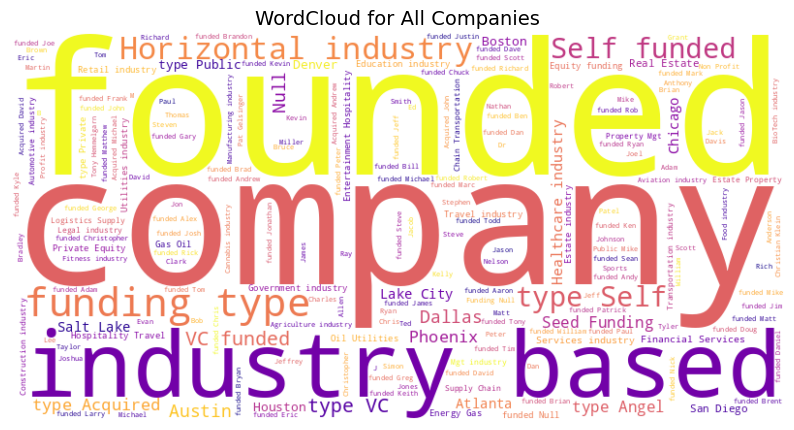

In [ ]:
# -------------------------------
# Step 6: NLP Summarization + WordCloud
# -------------------------------
def simple_summarize(text, n_sentences=2):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalnum() and w not in stop_words]

    freq = {}
    for w in words:
        freq[w] = freq.get(w, 0) + 1

    sentences = sent_tokenize(text)
    sentence_scores = {}
    for sent in sentences:
        for word in word_tokenize(sent.lower()):
            if word in freq:
                sentence_scores[sent] = sentence_scores.get(sent, 0) + freq[word]

    ranked = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
    summary = " ".join([s[0] for s in ranked[:n_sentences]])
    return summary if summary else text

def company_summary(keyword):
    results = df[df['description'].str.contains(keyword, case=False, na=False)]
    output = []
    if results.empty:
        return [f"No companies found for keyword: {keyword}"]
    for _, row in results.iterrows():
        entry = {
            "Company": row['company_name'],
            "Industry": row['industry'],
            "City": row['city'],
            "Summary": simple_summarize(str(row['description']))
        }
        output.append(entry)
    return output

print("\nSample Summaries for 'AI':")
print(company_summary("Agriculture")[:3])

# WordCloud
def generate_wordcloud(industry=None):
    if industry and "industry" in df.columns:
        text_data = " ".join(df[df['industry'] == industry]['description'].dropna().astype(str))
        title = f"WordCloud for {industry} Industry"
    else:
        text_data = " ".join(df['description'].dropna().astype(str))
        title = "WordCloud for All Companies"

    if not text_data.strip():
        print("No text data available.")
        return

    wc = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate(text_data)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Example
generate_wordcloud()

In [ ]:
# -------------------------------
# Step 6: Industry Betweenness
# -------------------------------
industry_centrality = df.groupby("industry")["Betweenness_Centrality"].mean().sort_values(ascending=False)

print("\nIndustry-wise Betweenness Centrality (Top 10):")
print(industry_centrality.head(10))


Industry-wise Betweenness Centrality (Top 10):
industry
Automotive        8.870294e-08
Horizontal        2.866008e-09
Agriculture       0.000000e+00
BioTech           0.000000e+00
Aviation          0.000000e+00
Cannabis          0.000000e+00
Clinical          0.000000e+00
Construction      0.000000e+00
CPG               0.000000e+00
Cryptocurrency    0.000000e+00
Name: Betweenness_Centrality, dtype: float64


In [ ]:
# Step 7: Top 2 Influential Companies per Industry (with Industry Name)
# -------------------------------
top_companies_by_industry = (
    df.groupby("industry", group_keys=False)
    .apply(lambda x: x.nlargest(2, "Betweenness_Centrality")[["industry", "company_name", "Betweenness_Centrality"]])
    .reset_index(drop=True)
)

print("\nTop 2 Influential Companies per Industry:")
print(top_companies_by_industry.head(20))


Top 2 Influential Companies per Industry:
                       industry             company_name  \
0                   Agriculture                Jim Baker   
1                   Agriculture             Marcel Cohen   
2                    Automotive                      NaN   
3                    Automotive              Laura Dihel   
4                      Aviation            John Bradford   
5                      Aviation          Azim Barodawala   
6                       BioTech              Ajit Nagral   
7                       BioTech       Cara Wessels Wells   
8                           CPG              Mike Mellin   
9                           CPG          Alfonso Vazquez   
10                     Cannabis           Colton Griffin   
11                     Cannabis      Mark Anthony Morris   
12                     Clinical                 Molly He   
13                     Clinical                  Lew Lim   
14                 Construction             Whit McIsaac 

/tmp/ipython-input-848472738.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(2, "Betweenness_Centrality")[["industry", "company_name", "Betweenness_Centrality"]])


In [ ]:
print("\nTop 2 Influential Companies per Industry:")
print(top_companies_by_industry.head(20))



Top 2 Influential Companies per Industry:
                       industry             company_name  \
0                   Agriculture                Jim Baker   
1                   Agriculture             Marcel Cohen   
2                    Automotive                      NaN   
3                    Automotive              Laura Dihel   
4                      Aviation            John Bradford   
5                      Aviation          Azim Barodawala   
6                       BioTech              Ajit Nagral   
7                       BioTech       Cara Wessels Wells   
8                           CPG              Mike Mellin   
9                           CPG          Alfonso Vazquez   
10                     Cannabis           Colton Griffin   
11                     Cannabis      Mark Anthony Morris   
12                     Clinical                 Molly He   
13                     Clinical                  Lew Lim   
14                 Construction             Whit McIsaac 

In [ ]:


# -------------------------------
# Step 8: Startups vs Established
# -------------------------------
if "Size_of_Company" in df.columns:
    startups = df[df["Size_of_Company"].str.contains("Startup", case=False, na=False)]
    established = df[~df["Size_of_Company"].str.contains("Startup", case=False, na=False)]
else:
    startups = pd.DataFrame()
    established = df

print("\nStartup count:", len(startups))
print("Established company count:", len(established))


Startup count: 1325
Established company count: 4275



Top 10 Startup Cities:
city
Phoenix           215
Austin            214
Null              206
Dallas            168
Houston           101
Atlanta            89
Chicago            85
Salt Lake City     72
San Diego          68
Denver             57
Name: count, dtype: int64


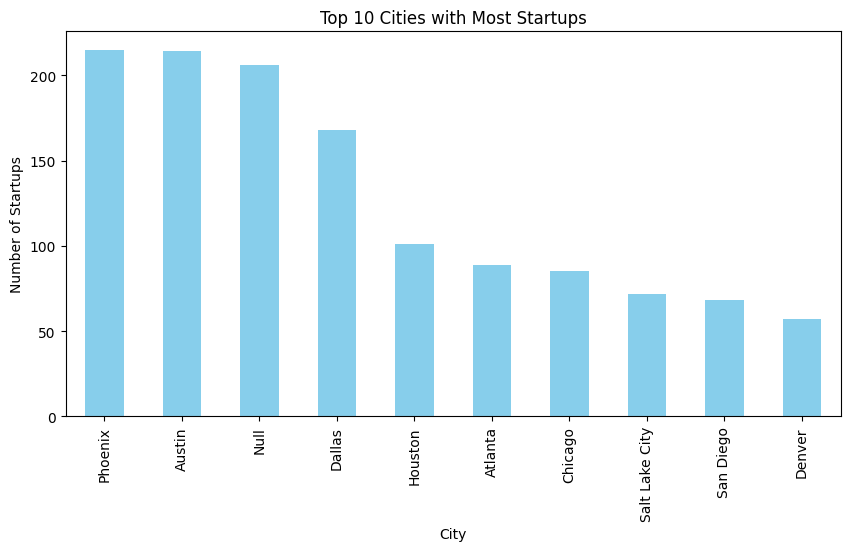

In [ ]:
# -------------------------------
# Step 9: City-wise Startup Hubs
# -------------------------------
if not startups.empty:
    city_startups = startups["city"].value_counts().head(10)
    print("\nTop 10 Startup Cities:")
    print(city_startups)

    plt.figure(figsize=(10,5))
    city_startups.plot(kind="bar", color="skyblue")
    plt.title("Top 10 Cities with Most Startups")
    plt.ylabel("Number of Startups")
    plt.xlabel("City")
    plt.show()

In [ ]:
# (A) Density & Connectivity
print("\nGraph Density:", nx.density(G))



Graph Density: 0.31398001756022326


In [ ]:

# (D) City + Industry Ecosystem
city_industry_groups = df.groupby(["city", "industry"]).size().reset_index(name="Count")

print("\nTop City+Industry combinations:")
print(city_industry_groups.sort_values("Count", ascending=False).head(15))

# (E) Funding Type vs Influence
funding_influence = df.groupby("Funding_Type")["Betweenness_Centrality"].mean().sort_values(ascending=False)

print("\nFunding Type vs Influence:")
print(funding_influence)

# (F) Time-based Evolution (Year Founded)
df["Year_Founded"] = pd.to_numeric(df["Year_Founded"], errors="coerce")
df["Decade"] = (df["Year_Founded"]//10)*10

decade_influence = df.groupby("Decade")["Betweenness_Centrality"].mean()

print("\nInfluence by Decade:")
print(decade_influence)


Top City+Industry combinations:
               city                     industry  Count
33           Austin                   Horizontal    455
157            Null                   Horizontal    430
93           Dallas                   Horizontal    388
177         Phoenix                   Horizontal    339
13          Atlanta                   Horizontal    267
72          Chicago                   Horizontal    263
53           Boston                   Horizontal    236
196  Salt Lake City                   Horizontal    234
114          Denver                   Horizontal    197
134         Houston                   Horizontal    150
217       San Diego                   Horizontal    136
92           Dallas                   Healthcare     99
176         Phoenix                   Healthcare     90
156            Null                   Healthcare     68
128         Houston  Energy, Gas, Oil, Utilities     55

Funding Type vs Influence:
Funding_Type
Acquired                  2.70

In [ ]:
# (B) K-core Decomposition
G.remove_edges_from(nx.selfloop_edges(G))
core_numbers = nx.core_number(G)
df["KCore"] = df["company_name"].map(core_numbers)

print("\nTop Companies by K-Core:")
print(df.sort_values("KCore", ascending=False).head(10)[["company_name","industry","KCore"]])


Top Companies by K-Core:
                   company_name    industry  KCore
5560  Jessica Velletri Akinwale  Horizontal   2570
5561          Michael Lieberman  Horizontal   2570
5562                       Null  Horizontal   2570
5563              Naman Budhdeo  Horizontal   2570
5567              Yoav Schwartz  Horizontal   2570
5552                  Kv Suresh  Horizontal   2570
5553                       Null    Cannabis   2570
5555               Mike Sevigny  Horizontal   2570
5557         Akshay Vishwakarma  Horizontal   2570
5559         Christina Yuhanova  Horizontal   2570


In [ ]:
# (C) Cross-Industry Bridges
bridges = []
for u, v in G.edges():
    if G.nodes[u]["industry"] != G.nodes[v]["industry"]:
        bridges.append((u, v))

print("\nSample cross-industry bridges:", bridges[:10])


Sample cross-industry bridges: [('Kelly Duncan', 'Null'), ('Kelly Duncan', 'Tim Turner'), ('Kelly Duncan', 'Andy Ruse'), ('Kelly Duncan', 'Andy Jassy'), ('Kelly Duncan', 'Jim Milton'), ('Kelly Duncan', 'Shion Deysarkar'), ('Kelly Duncan', 'Scott Burgess'), ('Kelly Duncan', 'John Wright'), ('Kelly Duncan', 'James Sullivan'), ('Kelly Duncan', 'Rahul Sharma')]


In [ ]:
import json
import networkx as nx

# Save the graph data to a JSON file
graph_data = nx.node_link_data(G)
with open("sna_data.json", "w") as f:
    json.dump(graph_data, f)

# Now download the file
from google.colab import files
files.download("sna_data.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>